# Introduction

The plan of studying Neural Tangent Kernel (NTK).

- Study the Neural Tangent Library by Google
- Reproduce several works published in 2019 focusing on the basic property of NTK and being familiar with the code
- TBD

# Library

The following paper contains the development of the [neural-tangents](https://github.com/google/neural-tangents) library

- [Neural Tangents: Fast and Easy Infinite Neural Networks in Python](https://arxiv.org/abs/1912.02803)
- [Fast Finite Width Neural Tangent Kernel](https://arxiv.org/abs/2206.08720)
- [Infinite attention: NNGP and NTK for deep attention networks](https://arxiv.org/abs/2006.10540)
- [On the infinite width limit of neural networks with a standard parameterization](https://arxiv.org/abs/2001.07301)
- [Fast Neural Kernel Embeddings for General Activations](https://arxiv.org/abs/2209.04121)

# Prerequisites

Some basic knowledge of Deep Neural Network(DNN) needed in understanding NTK

- Neural Networks are build using principle of neuronal organization discovered by connection in the biological neural networks constituting animal brains. It is loosely modeled by stacking layers of neurons. Such architecture is also called Multi-Layer Perceptron (MLP).
- [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that `1-layer` MLP has capability in modeling any function with the following condition:
  - The input dimension is smaller than the number of neurons. Actually, it needs to be far less.
  - The continuous function is in Euclidean Space
- In practice, the width (number of neurons in a single layer) cannot go to infinity. To overcome this limitation, `n-layers` MLP (a.k.a. DNN) was invented with the following setup:
  - Activation function between layers. Without activation function, `n-layers` MLP will be mathematically equivalent to `1-layer` MLP due to linearity. That says activation involves non-linearity for DNN.
  - A typical DNN will have at least `2-layers` so that there will be a place for activation function in between layers. **That's why so many theories focusing on analyzing `2-layers` MLP architecture**.
- Empirically, the DNN is more powerful than it sounds to be (i.e. beyond the Universal Approximation Theorem) as follows:
  - DNN not only shows superior performance in approximation but also in prediction (generalization, beyond human accuracy).
  - DNN is not limited to Euclidean Space
- Some architectures are designed to further improve the performance of the DNN, empirically, with loosely theoretically analysis:
  - Batch Normalization (faster convergence)
  - Dropout (non-linearity for generalization)
  - Initialization (Better overall performance)
  - ReLU (Overcome Gradient Explosion)
  - ResNet (Overcome Gradient Vanish)
  - CNN (Computer Vision)
  - Transformer (Human knowledge Prior)
  - Diffusion (Mimic Optimal Transportation)
  - RNN, Knowledge Distillation, etc.
- Some Theory Framework (Trick?)
  - Neural Ordinary Differential Equation and Neural Partial Differential Equation. Traditional deep neural networks can be thought of as discretized transformations of data across layers. Neural Differential Equations replace these discrete transformations with a continuous transformation.
  - Mean Field Theory to analyze the Optimization Dynamic at Initialization.
  - **`Neural Tangent Kernel to analyze the infinity width DNN`**.

# Neural-Tangents Library

## Basic Usage is similar to Jax

In [14]:
from jax import random
from neural_tangents import stax

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(1)
)

key1, key2 = random.split(random.PRNGKey(1))
x1 = random.normal(key1, (10, 100))
x2 = random.normal(key2, (20, 100))

nngp, ntk = kernel_fn(x1, x2, ('nngp', 'ntk'))

In [15]:
import neural_tangents as nt

x_train, x_test = x1, x2
y_train = random.uniform(key1, shape=(10, 1))  # training targets

predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, x_train,
                                                      y_train)

y_test_nngp = predict_fn(x_test=x_test, get='nngp')
# (20, 1) jnp.ndarray test predictions of an infinite Bayesian network

y_test_ntk = predict_fn(x_test=x_test, get='ntk')
# (20, 1) jnp.ndarray test predictions of an infinite continuous
# gradient descent trained network at convergence (t = inf)

# Get predictions as a namedtuple
both = predict_fn(x_test=x_test, get=('nngp', 'ntk'))
both.nngp == y_test_nngp  # True
both.ntk == y_test_ntk  # True

# Unpack the predictions namedtuple
y_test_nngp, y_test_ntk = predict_fn(x_test=x_test, get=('nngp', 'ntk'))

In [17]:
from neural_tangents import stax

def WideResnetBlock(channels, strides=(1, 1), channel_mismatch=False):
  Main = stax.serial(
      stax.Relu(), stax.Conv(channels, (3, 3), strides, padding='SAME'),
      stax.Relu(), stax.Conv(channels, (3, 3), padding='SAME'))
  Shortcut = stax.Identity() if not channel_mismatch else stax.Conv(
      channels, (3, 3), strides, padding='SAME')
  return stax.serial(stax.FanOut(2),
                     stax.parallel(Main, Shortcut),
                     stax.FanInSum())

def WideResnetGroup(n, channels, strides=(1, 1)):
  blocks = []
  blocks += [WideResnetBlock(channels, strides, channel_mismatch=True)]
  for _ in range(n - 1):
    blocks += [WideResnetBlock(channels, (1, 1))]
  return stax.serial(*blocks)

def WideResnet(block_size, k, num_classes):
  return stax.serial(
      stax.Conv(16, (3, 3), padding='SAME'),
      WideResnetGroup(block_size, int(16 * k)),
      WideResnetGroup(block_size, int(32 * k), (2, 2)),
      WideResnetGroup(block_size, int(64 * k), (2, 2)),
      stax.AvgPool((8, 8)),
      stax.Flatten(),
      stax.Dense(num_classes, 1., 0.))

init_fn, apply_fn, kernel_fn = WideResnet(block_size=4, k=1, num_classes=10)

## NTK Cookbook

In [22]:
import jax.numpy as jnp

from jax import random
from jax.example_libraries import optimizers
from jax import jit, grad, vmap

import functools

import neural_tangents as nt
from neural_tangents import stax

**Setup Visualization**

In [24]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns

sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})

import matplotlib.pyplot as plt

def format_plot(x=None, y=None):
  # plt.grid(False)
  ax = plt.gca()
  if x is not None:
    plt.xlabel(x, fontsize=20)
  if y is not None:
    plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

legend = functools.partial(plt.legend, fontsize=10)

def plot_fn(train, test, *fs):
  train_xs, train_ys = train

  plt.plot(train_xs, train_ys, 'ro', markersize=10, label='train')

  if test != None:
    test_xs, test_ys = test
    plt.plot(test_xs, test_ys, 'k--', linewidth=3, label='$f(x)$')

    for f in fs:
      plt.plot(test_xs, f(test_xs), '-', linewidth=3)

  plt.xlim([-jnp.pi, jnp.pi])
  plt.ylim([-1.5, 1.5])

  format_plot('$x$', '$f$')

/tmp/ipykernel_1686/1909444407.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


**Setup Loss Function**

In [25]:
def loss_fn(predict_fn, ys, t, xs=None):
  mean, cov = predict_fn(t=t, get='ntk', x_test=xs, compute_cov=True)
  mean = jnp.reshape(mean, mean.shape[:1] + (-1,))
  var = jnp.diagonal(cov, axis1=1, axis2=2)
  ys = jnp.reshape(ys, (1, -1))

  mean_predictions = 0.5 * jnp.mean(ys ** 2 - 2 * mean * ys + var + mean ** 2,
                                   axis=1)

  return mean_predictions

**Setup Dataset**

- $y=f(x)+\varepsilon$ where $f(x)=sin(x)$ and $x \in [-\pi, \pi]$, $\varepsilon \in Gaussian(0,1)$
- train_xs is $x \in [-\pi, \pi]$
- train_ys is $y = sin(x)+\varepsilon$
- test_xs is $x \in [-\pi, \pi]$
- test_ys is $y = sin(x)$
- We want to train a regressor $A$, which approximate sinusoidal function $sin(x)$ such that $y=Ax$ and $\min ||\varepsilon||_2^2$



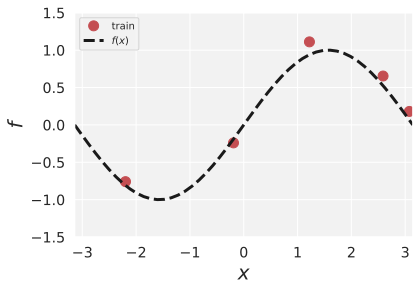

In [26]:
key = random.PRNGKey(10)

train_points = 5
test_points = 50
noise_scale = 1e-1

target_fn = lambda x: jnp.sin(x)

key, x_key, y_key = random.split(key, 3)

train_xs = random.uniform(x_key, (train_points, 1), minval=-jnp.pi, maxval=jnp.pi)

train_ys = target_fn(train_xs)
train_ys += noise_scale * random.normal(y_key, (train_points, 1))
train = (train_xs, train_ys)

test_xs = jnp.linspace(-jnp.pi, jnp.pi, test_points)
test_xs = jnp.reshape(test_xs, (test_points, 1))

test_ys = target_fn(test_xs)
test = (test_xs, test_ys)

plot_fn(train, test)
legend(loc='upper left')
finalize_plot((0.85, 0.6))

**Defining a Neural Network**

In [27]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(512, W_std=1.5, b_std=0.05), stax.Erf(),
    stax.Dense(1, W_std=1.5, b_std=0.05)
)

apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnames='get')

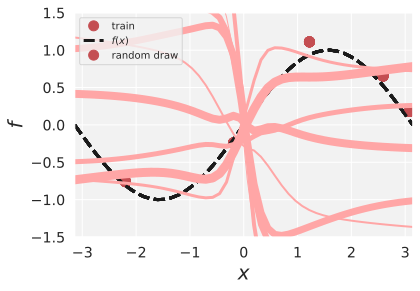

In [33]:
prior_draws = []
for _ in range(10):
    key, net_key = random.split(key)
    _, params = init_fn(net_key, (-1, 1))
    prior_draws += [apply_fn(params, test_xs)]

    plot_fn(train, test)

for (i, p) in enumerate(prior_draws):
    plt.plot(test_xs, p, linewidth=i, color=[1, 0.65, 0.65])

legend(['train', '$f(x)$', 'random draw'], loc='upper left')

finalize_plot((0.85, 0.6))

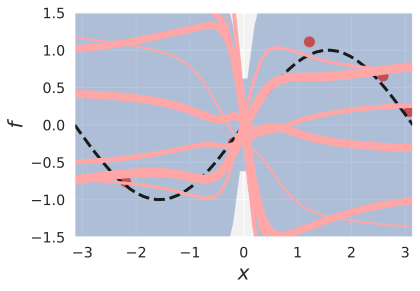

In [35]:
kernel = kernel_fn(test_xs, test_xs, 'nngp')
std_dev = jnp.sqrt(jnp.diag(kernel))

plot_fn(train, test)

plt.fill_between(
    jnp.reshape(test_xs, (-1,)), 2 * std_dev, -2 * std_dev, alpha=0.4)

for (i,p) in enumerate(prior_draws):
  plt.plot(test_xs, p, linewidth=i, color=[1, 0.65, 0.65])

finalize_plot((0.85, 0.6))

As shown above, the kernel (NTK) of the neural network derived from the infinity width condition perform exactly as the Gaussian Process.

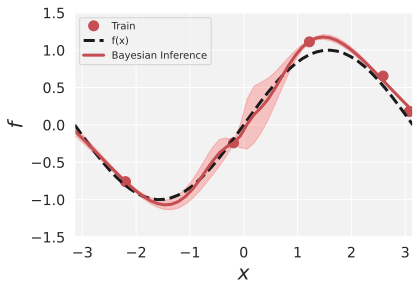

In [36]:
predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, train_xs,
                                                      train_ys, diag_reg=1e-4)

nngp_mean, nngp_covariance = predict_fn(x_test=test_xs, get='nngp',
                                        compute_cov=True)

nngp_mean = jnp.reshape(nngp_mean, (-1,))
nngp_std = jnp.sqrt(jnp.diag(nngp_covariance))

plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    jnp.reshape(test_xs, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean +  2 * nngp_std,
    color='red', alpha=0.2)

plt.xlim([-jnp.pi, jnp.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference'], loc='upper left')

finalize_plot((0.85, 0.6))

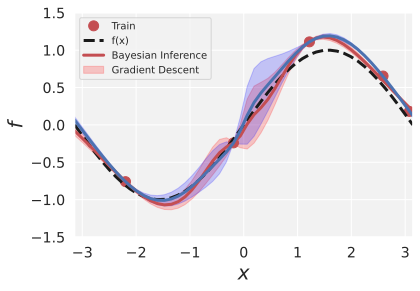

In [37]:
ntk_mean, ntk_covariance = predict_fn(x_test=test_xs, get='ntk',
                                      compute_cov=True)

ntk_mean = jnp.reshape(ntk_mean, (-1,))
ntk_std = jnp.sqrt(jnp.diag(ntk_covariance))

plot_fn(train, test)

plt.plot(test_xs, nngp_mean, 'r-', linewidth=3)
plt.fill_between(
    jnp.reshape(test_xs, (-1)),
    nngp_mean - 2 * nngp_std,
    nngp_mean +  2 * nngp_std,
    color='red', alpha=0.2)


plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    jnp.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.xlim([-jnp.pi, jnp.pi])
plt.ylim([-1.5, 1.5])

legend(['Train', 'f(x)', 'Bayesian Inference', 'Gradient Descent'],
       loc='upper left')

finalize_plot((0.85, 0.6))

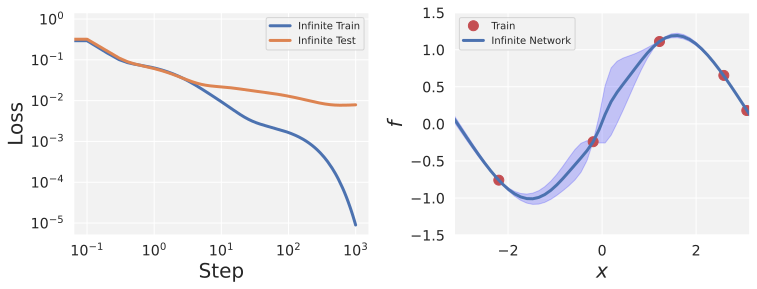

In [38]:
ts = jnp.arange(0, 10 ** 3, 10 ** -1)
ntk_train_loss_mean = loss_fn(predict_fn, train_ys, ts)
ntk_test_loss_mean = loss_fn(predict_fn, test_ys, ts, test_xs)

plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)
format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    jnp.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

legend(
    ['Train', 'Infinite Network'],
    loc='upper left')

finalize_plot((1.5, 0.6))

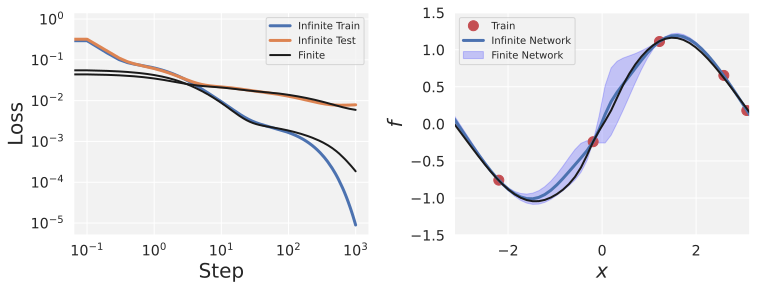

In [39]:
learning_rate = 0.1
training_steps = 10000

opt_init, opt_update, get_params = optimizers.sgd(learning_rate)
opt_update = jit(opt_update)

loss = jit(lambda params, x, y: 0.5 * jnp.mean((apply_fn(params, x) - y) ** 2))
grad_loss = jit(lambda state, x, y: grad(loss)(get_params(state), x, y))

train_losses = []
test_losses = []

opt_state = opt_init(params)

for i in range(training_steps):
  opt_state = opt_update(i, grad_loss(opt_state, *train), opt_state)

  train_losses += [loss(get_params(opt_state), *train)]
  test_losses += [loss(get_params(opt_state), *test)]

plt.subplot(1, 2, 1)

plt.loglog(ts, ntk_train_loss_mean, linewidth=3)
plt.loglog(ts, ntk_test_loss_mean, linewidth=3)

plt.loglog(ts, train_losses, 'k-', linewidth=2)
plt.loglog(ts, test_losses, 'k-', linewidth=2)

format_plot('Step', 'Loss')
legend(['Infinite Train', 'Infinite Test', 'Finite'])

plt.subplot(1, 2, 2)

plot_fn(train, None)

plt.plot(test_xs, ntk_mean, 'b-', linewidth=3)
plt.fill_between(
    jnp.reshape(test_xs, (-1)),
    ntk_mean - 2 * ntk_std,
    ntk_mean +  2 * ntk_std,
    color='blue', alpha=0.2)

plt.plot(test_xs, apply_fn(get_params(opt_state), test_xs), 'k-', linewidth=2)

legend(
    ['Train', 'Infinite Network', 'Finite Network'],
    loc='upper left')

finalize_plot((1.5, 0.6))